In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 10개 파일을 불러왔습니다: 1201.csv, 137.csv, 281.csv, 397.csv, 401.csv, 430.csv, 514.csv, 524.csv, 775.csv, 89.csv
📊 데이터 Shape: I=10, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=768.00, M2=2463.00


모두 포함 최적화 (holistic aggregation)

In [2]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p1")
p2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p2")
p3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p3")
p4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p4")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] + zc[i, t, s] <= R[i, t, s] + zd[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * p4[i, t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - p4[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_opt = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
a_opt = np.sum(x_opt, axis=0)
yp_opt = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_opt = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_opt = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_opt = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_opt = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ep_opt = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
bp_opt = np.sum(ep_opt, axis=0) 
em_opt = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
bm_opt = np.sum(em_opt, axis=0) 
d_opt = np.array([[[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
dp_opt = np.sum(d_opt, axis=1)
dm_opt = np.sum(d_opt, axis=0)

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 81800 rows, 101240 columns and 365000 nonzeros
Model fingerprint: 0x3e071c75
Variable types: 82040 continuous, 19200 integer (19200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 42679 rows and 40264 columns
Presolve time: 0.36s
Presolved: 39121 rows, 60976 columns, 167340 nonzeros
Variable types: 51651 continuous, 9325 integer (9325 binary)
Found heuristic solution: objective 1162576.6909
Deterministic concurrent LP optimizer: primal and dual sim

target_i 제외 최적화

In [49]:
def optimize_without(target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    I_set = [i for i in range(I) if i != target_i]
    M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
    M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

    model = gp.Model(f"set_without_{target_i}")
    model.setParam("MIPGap", 1e-7)
    model.setParam("OutputFlag", 0)

    x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
    em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
    yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
    zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
    zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
    d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

    p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
    p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
    p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
    p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

    obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
        (1 / S) * (
            P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
            P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
        )
        for t in range(T) for s in range(S)
    )
    model.setObjective(obj, GRB.MAXIMIZE)

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
        model.addConstr(yp[i, t, s] + zc[i, t, s] <= R[i, t, s] + zd[i, t, s])
        model.addConstr(zd[i, t, s] <= z[i, t, s])
        model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
        model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
        model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
        model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
        model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
        model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
        model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
        model.addConstr(z[i, t, s] <= K[i])
        model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

    for i, s in product(I_set, range(S)):
        model.addConstr(z[i, 0, s] == K0[i])

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
        model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
        model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
        model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
        model.addConstr(d[i, i, t, s] == 0)

    model.optimize()

    i_map = {i: idx for idx, i in enumerate(I_set)}

    x_vals = np.array([[x[i, t].X for t in range(T)] for i in I_set])
    ep_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    em_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])
    dp_vals = np.sum(d_vals, axis=1)
    dm_vals = np.sum(d_vals, axis=0)

    return x_vals, ep_vals, em_vals, yp_vals, ym_vals, d_vals, dp_vals, dm_vals, i_map

In [50]:
def optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    x_without = {}; ep_without = {}; em_without = {}
    yp_without = {}; ym_without = {}; d_without = {}; dp_without = {}; dm_without = {}; i_map_without = {}

    for target_i in tqdm(range(I), desc="Solving settlement model for each target DER"):
        x_vals, ep_vals, em_vals, yp_vals, ym_vals, d_vals,  dp_vals, dm_vals, i_map = optimize_without(
            target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S
        )
        x_without[target_i] = x_vals
        ep_without[target_i] = ep_vals
        em_without[target_i] = em_vals
        yp_without[target_i] = yp_vals
        ym_without[target_i] = ym_vals
        d_without[target_i] = d_vals
        dp_without[target_i] = dp_vals
        dm_without[target_i] = dm_vals
        i_map_without[target_i] = i_map

    return x_without, ep_without, em_without, yp_without, ym_without, d_without, dp_without, dm_without, i_map_without

In [51]:
x_without, ep_without, em_without, yp_without, ym_without, d_without, dp_without, dm_without, i_map_without = optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S)

Solving settlement model for each target DER:   0%|          | 0/10 [00:00<?, ?it/s]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  10%|█         | 1/10 [01:36<14:31, 96.83s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  20%|██        | 2/10 [01:58<06:58, 52.37s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  30%|███       | 3/10 [02:14<04:12, 36.06s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  40%|████      | 4/10 [02:40<03:12, 32.01s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  50%|█████     | 5/10 [02:56<02:10, 26.07s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  60%|██████    | 6/10 [04:02<02:39, 39.80s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  70%|███████   | 7/10 [04:32<01:49, 36.46s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  80%|████████  | 8/10 [04:50<01:01, 30.58s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  90%|█████████ | 9/10 [05:11<00:27, 27.65s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER: 100%|██████████| 10/10 [05:37<00:00, 33.75s/it]


In [52]:
def compute_price_functions(
    yp_without, ym_without, d_without, i_map_without,
    P_RT, P_PN, T, S, I
):
    rdc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rsc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rho_plus_func_all = np.full((I, T, S, 2), np.nan)   # RDC
    rho_minus_func_all = np.full((I, T, S, 2), np.nan)  # RSC
    
    total_demand_all = np.zeros((I, T, S))
    total_supply_all = np.zeros((I, T, S))

    for target_i in range(I):
        yp_vals = yp_without[target_i]
        ym_vals = ym_without[target_i]
        d_vals = d_without[target_i]
        i_map = i_map_without[target_i]

        for t in range(T):
            for s in range(S):
                total_supply = sum(yp_vals[i_map[i], t, s] for i in i_map)
                total_demand = sum(ym_vals[i_map[i], t, s] for i in i_map)
                
                total_supply_all[target_i, t, s] = total_supply
                total_demand_all[target_i, t, s] = total_demand

                given_profit = received_profit = realized_supply = realized_demand = 0
                for i in i_map:
                    for j in i_map:
                        if i == j: continue
                        given_profit += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]
                        received_profit += d_vals[i_map[j], i_map[i], t, s] * P_RT[t, s]
                        realized_supply += d_vals[i_map[i], i_map[j], t, s]
                        realized_demand += d_vals[i_map[j], i_map[i], t, s]

                BIG_M_POS = 1e15
                BIG_M_NEG = -1e15

                if realized_demand <= 1e-4 or realized_supply <= 1e-4:
                    rho_plus_func_all[target_i, t, s, :] = [BIG_M_NEG, 0.0]
                    rho_minus_func_all[target_i, t, s, :] = [BIG_M_POS, 0.0]
                    continue

                a_d = P_PN[t]
                b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2)
                a_s = P_RT[t, s]
                b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2)

                denom = b_d + b_s
                if abs(denom) < 1e-6:
                    continue

                # === RDC: q0 → 공급 증가 ===
                q0_list_rdc = np.linspace(-5, 1.1 * total_supply, 100)
                prices_rdc = []
                for q0 in q0_list_rdc:
                    q_cleared = (a_d - a_s + b_s * q0) / denom
                    p_cleared = a_d - b_d * q_cleared
                    prices_rdc.append(p_cleared)
                q_rdc = np.array(q0_list_rdc).reshape(-1, 1)
                p_rdc = np.array(prices_rdc)

                # === RSC: q0 → 수요 증가 ===
                q0_list_rsc = np.linspace(-5, 1.1 * total_demand, 100)
                prices_rsc = []
                for q0 in q0_list_rsc:
                    q_cleared = (a_d + b_d * q0 - a_s) / denom
                    p_cleared = a_s + b_s * q_cleared
                    prices_rsc.append(p_cleared)
                q_rsc = np.array(q0_list_rsc).reshape(-1, 1)
                p_rsc = np.array(prices_rsc)

                # 선형 회귀 근사 (1차)
                X_poly_rdc = PolynomialFeatures(degree=1).fit_transform(q_rdc)
                X_poly_rsc = PolynomialFeatures(degree=1).fit_transform(q_rsc)

                model_rdc = LinearRegression().fit(X_poly_rdc, p_rdc)
                model_rsc = LinearRegression().fit(X_poly_rsc, p_rsc)

                a_rdc, b_rdc = model_rdc.intercept_, model_rdc.coef_[1]
                a_rsc, b_rsc = model_rsc.intercept_, model_rsc.coef_[1]

                rho_plus_func_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rho_minus_func_all[target_i, t, s, :] = [a_rsc, b_rsc]
                rdc_coefficients_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rsc_coefficients_all[target_i, t, s, :] = [a_rsc, b_rsc]

    return rdc_coefficients_all, rsc_coefficients_all, rho_plus_func_all, rho_minus_func_all, total_demand_all, total_supply_all

In [53]:
rdc, rsc, rho_plus, rho_minus, total_demand, total_supply = compute_price_functions(
    yp_without, ym_without, d_without, i_map_without,
    P_RT, P_PN, T, S, I
)

In [54]:
# 인덱스 설정
target_i = 1
t = 19
s = 3

# 가격 함수 계수 추출
ap, bp = rho_plus[target_i, t, s, :]
am, bm = rho_minus[target_i, t, s, :]

print(f"ρ⁺(d) = {ap:.2f} + {bp:.2f}·d")
print(f"ρ⁻(d) = {am:.2f} + {bm:.2f}·d")

ρ⁺(d) = 151.36 + -0.50·d
ρ⁻(d) = 151.36 + 0.50·d


In [55]:
def transform_pwl(rho_plus, rho_minus, total_demand, total_supply):
    """
    [목적]
        - 각 (i, t, s)별로 주어진 선형 함수 rho(q) = a + b*q 를
          total_supply[i,t,s], total_demand[i,t,s]에 따라 조각 수 B를 다르게 나눠 
          (q_b, p_b) stepwise 근사치로 계산한다.

    [입력]
        rho_plus, rho_minus: (I, T, S, 2) 배열, 각 [a, b] 계수 포함
        total_demand, total_supply: (I, T, S) 배열, 해당 시간/시나리오별 최대 수요·공급

    [출력]
        Tuple: (rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus)
        - rho_plus_piece[i][t][s]: (Bₚ, 2) array of [q_b, p_b]
        - rho_minus_piece[i][t][s]: (Bₘ, 2) array of [q_b, p_b]
        - B_map_plus, B_map_minus: 각 (i,t,s)별 B 값 저장
    """

    I, T, S, _ = rho_plus.shape
    rho_plus_piece = [[[
        None for _ in range(S)
    ] for _ in range(T)] for _ in range(I)]
    rho_minus_piece = [[[
        None for _ in range(S)
    ] for _ in range(T)] for _ in range(I)]

    B_map_plus = np.zeros((I, T, S), dtype=int)
    B_map_minus = np.zeros((I, T, S), dtype=int)

    for i in range(I):
        for t in range(T):
            for s in range(S):
                # ➤ RDC 
                a_p, b_p = rho_plus[i, t, s]
                B_p = max(1, int(np.ceil(total_supply[i, t, s])))
                q_vals_p = np.linspace(0, total_supply[i, t, s], B_p + 1)
                q_left_p = q_vals_p[:-1]
                rho_plus_piece[i][t][s] = np.array([[q_b, a_p + b_p * q_b] for q_b in q_left_p])
                B_map_plus[i, t, s] = B_p

                # ➤ RSC
                a_m, b_m = rho_minus[i, t, s]
                B_m = max(1, int(np.ceil(total_demand[i, t, s])))
                q_vals_m = np.linspace(0, total_demand[i, t, s], B_m + 1)
                q_left_m = q_vals_m[:-1]
                rho_minus_piece[i][t][s] = np.array([[q_b, a_m + b_m * q_b] for q_b in q_left_m])
                B_map_minus[i, t, s] = B_m

    return rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus

In [56]:
rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus = transform_pwl(rho_plus, rho_minus, total_demand, total_supply)

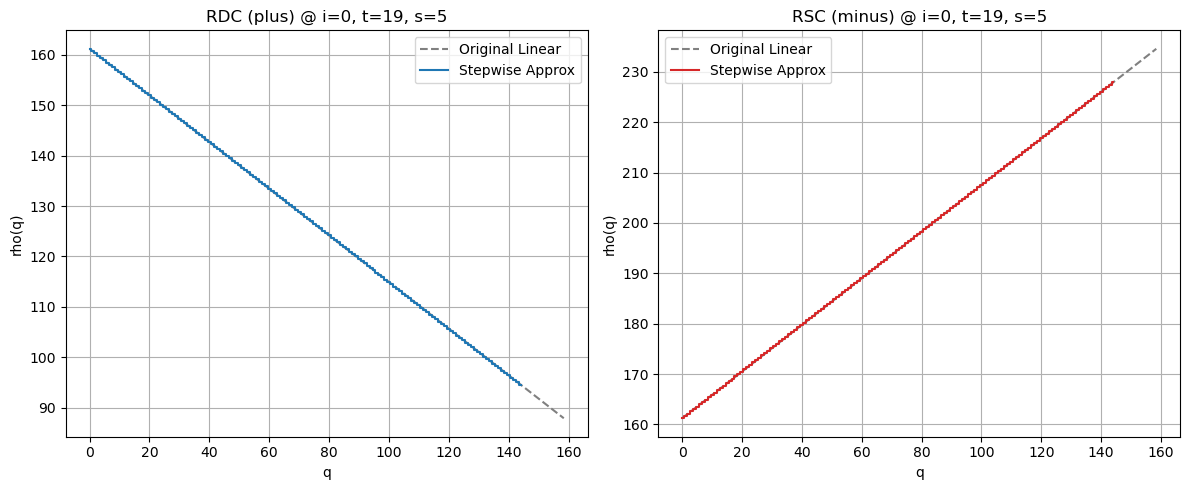

In [57]:
def plot_rho_stepwise_list(rho_plus, rho_minus, rho_plus_piece, rho_minus_piece, target_i, target_t, target_s):
    """
    [목적]
        - 선택된 (i, t, s)에 대해 선형 가격 함수와 stepwise 근사 결과를 함께 시각화

    [입력]
        rho_plus, rho_minus: 원본 선형 계수 (I, T, S, 2)
        rho_plus_piece, rho_minus_piece: 각 (i,t,s)별 계단형 근사 [q_b, p_b] 리스트
        target_i, target_t, target_s: 시각화할 대상 인덱스
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['RDC (plus)', 'RSC (minus)']
    colors = ['tab:blue', 'tab:red']
    rho_data = [rho_plus, rho_minus]
    pwl_data = [rho_plus_piece, rho_minus_piece]

    for idx, (rho, pwl_piece, ax, label, color) in enumerate(zip(
        rho_data, pwl_data, axes, labels, colors
    )):
        a, b = rho[target_i, target_t, target_s]
        piecewise = pwl_piece[target_i][target_t][target_s]  # shape (B, 2)
        q_vals = piecewise[:, 0]
        p_vals = piecewise[:, 1]

        # 원본 선형함수
        q_cont = np.linspace(0, max(q_vals) * 1.1 if np.any(q_vals > 0) else 1.0, 200)
        p_cont = a + b * q_cont
        ax.plot(q_cont, p_cont, '--', label='Original Linear', color='gray')

        # 계단형 근사
        ax.step(q_vals, p_vals, where='mid', label='Stepwise Approx', color=color)

        ax.set_title(f"{label} @ i={target_i}, t={target_t}, s={target_s}")
        ax.set_xlabel("q")
        ax.set_ylabel("rho(q)")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_rho_stepwise_list(
    rho_plus, rho_minus, 
    rho_plus_piece, rho_minus_piece, 
    target_i=0, target_t=19, target_s=5
)

Model (Linear)

In [58]:
x_pwl, yp_pwl, ym_pwl, z_pwl, zc_pwl, zd_pwl, dp_pwl, dm_pwl = [], [], [], [], [], [], [], []
model_pwl = []

for target_i in tqdm(range(I), desc="Optimizing PWL for each target_i"):
    # === 모델 생성 ===
    model = gp.Model("PWL_Internal_Optimization_{target_i}")
    model.setParam("OutputFlag", 0)
    model.setParam("MIPGap", 1e-7)

    # === 변수 정의 ===
    x = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    yp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(T+1, S, vtype=GRB.CONTINUOUS, lb=0, name="z")
    zc = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_charge")
    zd = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_discharge")
    dp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_plus")
    dm = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_minus")

    p1  = model.addVars(T, S, vtype=GRB.BINARY, name="p1")
    p2  = model.addVars(T, S, vtype=GRB.BINARY, name="p2")
    p3  = model.addVars(T, S, vtype=GRB.BINARY, name="p3")
    p4  = model.addVars(T, S, vtype=GRB.BINARY, name="p4")
    p5  = model.addVars(T, S, vtype=GRB.BINARY, name="p5")
    p6  = model.addVars(T, S, vtype=GRB.BINARY, name="p6")
    p7  = model.addVars(T, S, vtype=GRB.BINARY, name="p7")
    p8  = model.addVars(T, S, vtype=GRB.BINARY, name="p8")

    # Stepwise variables
    w_plus, u_plus = {}, {}
    w_minus, u_minus = {}, {}

    for t in range(T):
        for s in range(S):
            Bp = B_map_plus[target_i, t, s]
            Bm = B_map_minus[target_i, t, s]
            for b in range(Bp):
                w_plus[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_plus_{t}_{s}_{b}")
                u_plus[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_plus_{t}_{s}_{b}")
            for b in range(Bm):
                w_minus[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_minus_{t}_{s}_{b}")
                u_minus[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_minus_{t}_{s}_{b}")

    model.update()

    # === 목적함수 정의 ===
    obj = gp.quicksum(P_DA[t] * x[t] for t in range(T)) \
        + gp.quicksum((1/S) * (P_RT[t, s] * yp[t, s] - P_PN[t] * ym[t, s]) for t in range(T) for s in range(S)) \
        + gp.quicksum((1/S) * (
            gp.quicksum(
                rho_plus_piece[target_i][t][s][b][1] * (w_plus[t, s, b] + u_plus[t, s, b] * rho_plus_piece[target_i][t][s][b][0])
                for b in range(B_map_plus[target_i, t, s])
            ) -
            gp.quicksum(
                rho_minus_piece[target_i][t][s][b][1] * (w_minus[t, s, b] + u_minus[t, s, b] * rho_minus_piece[target_i][t][s][b][0])
                for b in range(B_map_minus[target_i, t, s])
            )
        ) for t in range(T) for s in range(S))

    model.setObjective(obj, GRB.MAXIMIZE)

    # === 제약식 ===
    for t, s in product(range(T), range(S)):
        # 기본 수지식
        model.addConstr(R[target_i, t, s] - x[t] == yp[t, s] - ym[t, s] + zc[t, s] - zd[t, s] + dp[t, s] - dm[t, s])
        model.addConstr(yp[t, s] + dp[t, s] + zc[t, s] <= R[target_i, t, s] + zd[t, s])
        model.addConstr(z[t+1, s] == z[t, s] + zc[t, s] - zd[t, s])
        model.addConstr(zd[t, s] <= z[t, s])
        model.addConstr(zc[t, s] <= K[target_i] - z[t, s])
        model.addConstr(z[t, s] <= K[target_i])
        model.addConstr(z[t, s] >= 0)
        model.addConstr(yp[t, s] <= M1 * p1[t, s])
        model.addConstr(ym[t, s] <= M1 * (1 - p1[t, s]))
        model.addConstr(ym[t, s] <= M1 * p2[t, s])
        model.addConstr(zc[t, s] <= M1 * (1 - p2[t, s]))
        model.addConstr(zc[t, s] <= M1 * p3[t, s])
        model.addConstr(zd[t, s] <= M1 * (1 - p3[t, s]))
        model.addConstr(dp[t, s] <= M1 * p4[t, s])
        model.addConstr(dm[t, s] <= M1 * (1 - p4[t, s]))
        # model.addConstr(ym[t, s] <= M1 * p5[t, s])
        # model.addConstr(dp[t, s] <= M1 * (1 - p5[t, s]))
        # model.addConstr(yp[t, s] <= M1 * p6[t, s])
        # model.addConstr(dm[t, s] <= M1 * (1 - p6[t, s]))
        # model.addConstr(zc[t, s] <= M1 * p7[t, s])
        # model.addConstr(dm[t, s] <= M1 * (1 - p7[t, s]))
        # model.addConstr(zd[t, s] <= M1 * p8[t, s])
        # model.addConstr(dp[t, s] <= M1 * (1 - p8[t, s]))

        # piecewise aggregation
        model.addConstr(dp[t, s] == gp.quicksum(w_plus[t, s, b] + u_plus[t, s, b] * rho_plus_piece[target_i][t][s][b][0]
                                                for b in range(B_map_plus[target_i, t, s])))
        model.addConstr(dm[t, s] == gp.quicksum(w_minus[t, s, b] + u_minus[t, s, b] * rho_minus_piece[target_i][t][s][b][0]
                                                for b in range(B_map_minus[target_i, t, s])))

        model.addConstr(gp.quicksum(u_plus[t, s, b] for b in range(B_map_plus[target_i, t, s])) <= 1)
        model.addConstr(gp.quicksum(u_minus[t, s, b] for b in range(B_map_minus[target_i, t, s])) <= 1)

        # for b in range(B_map_plus[target_i, t, s]):
        #     width = rho_plus_piece[target_i][t][s][b][0]
        #     model.addConstr(w_plus[t, s, b] <= u_plus[t, s, b] * width)
        # for b in range(B_map_minus[target_i, t, s]):
        #     width = rho_minus_piece[target_i][t][s][b][0]
        #     model.addConstr(w_minus[t, s, b] <= u_minus[t, s, b] * width)
            
        for b in range(B_map_plus[target_i, t, s]):
            if b < B_map_plus[target_i, t, s] - 1:
                width = rho_plus_piece[target_i][t][s][b + 1][0] - rho_plus_piece[target_i][t][s][b][0]
            else:
                width = 1e-6 
            model.addConstr(w_plus[t, s, b] <= u_plus[t, s, b] * width)

        for b in range(B_map_minus[target_i, t, s]):
            if b < B_map_minus[target_i, t, s] - 1:
                width = rho_minus_piece[target_i][t][s][b + 1][0] - rho_minus_piece[target_i][t][s][b][0]
            else:
                width = 1e-6
            model.addConstr(w_minus[t, s, b] <= u_minus[t, s, b] * width)

    # 초기 상태
    for s in range(S):
        model.addConstr(z[0, s] == K0[target_i])

    model.optimize()
    model_pwl.append(model)

    x_pwl.append(np.array([x[t].X for t in range(T)]))
    yp_pwl.append(np.array([[yp[t, s].X for s in range(S)] for t in range(T)]))
    ym_pwl.append(np.array([[ym[t, s].X for s in range(S)] for t in range(T)]))
    z_pwl.append(np.array([[z[t, s].X for s in range(S)] for t in range(T+1)]))
    zc_pwl.append(np.array([[zc[t, s].X for s in range(S)] for t in range(T)]))
    zd_pwl.append(np.array([[zd[t, s].X for s in range(S)] for t in range(T)]))
    dp_pwl.append(np.array([[dp[t, s].X for s in range(S)] for t in range(T)]))
    dm_pwl.append(np.array([[dm[t, s].X for s in range(S)] for t in range(T)]))

Optimizing PWL for each target_i: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


In [59]:
target_i = 2  # 원하는 인덱스로 바꿔서 사용

x_vals = x_pwl[target_i]
yp_vals = yp_pwl[target_i]
ym_vals = ym_pwl[target_i]
z_vals = z_pwl[target_i]
zc_vals = zc_pwl[target_i]
zd_vals = zd_pwl[target_i]
dp_vals = dp_pwl[target_i]
dm_vals = dm_pwl[target_i]

# 출력
header = (
    f"{'s':>2} {'t':>2} | "
    f"{'R':>8} {'x':>8} {'y+':>8} {'y-':>8} "
    f"{'d+':>8} {'d-':>8} {'zc':>8} {'zd':>8} {'z':>8}\n"
    + "-" * 90
)
print(header)

for s, t in product(range(S), range(T)):
    print(
        f"{s:>2} {t:>2} | "
        f"{R[target_i, t, s]:>8.2f} {x_vals[t]:>8.2f} {yp_vals[t, s]:>8.2f} {ym_vals[t, s]:>8.2f} "
        f"{dp_vals[t, s]:>8.2f} {dm_vals[t, s]:>8.2f} {zc_vals[t, s]:>8.2f} {zd_vals[t, s]:>8.2f} {z_vals[t, s]:>8.2f}"
    )

 s  t |        R        x       y+       y-       d+       d-       zc       zd        z
------------------------------------------------------------------------------------------
 0  0 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  1 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  2 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  3 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  4 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  5 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  6 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 0  7 |     5.00     0.00     0.00     0.00     0.00     0.00     5.00     0.00     0.00
 0  8 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     5.00
 0  9 |    10.00   

In [60]:
rho_plus_cleared = np.zeros((I, T, S))
rho_minus_cleared = np.zeros((I, T, S))

for target_i in range(I):
    model = model_pwl[target_i]

    for t in range(T):
        for s in range(S):
            # u_plus 중 선택된 b 찾기
            for b in range(B_map_plus[target_i, t, s]):
                var = model.getVarByName(f"u_plus_{t}_{s}_{b}")
                if round(var.X) == 1:
                    rho_plus_cleared[target_i, t, s] = rho_plus_piece[target_i][t][s][b][1]
                    break

            # u_minus 중 선택된 b 찾기
            for b in range(B_map_minus[target_i, t, s]):
                var = model.getVarByName(f"u_minus_{t}_{s}_{b}")
                if round(var.X) == 1:
                    rho_minus_cleared[target_i, t, s] = rho_minus_piece[target_i][t][s][b][1]
                    break

In [61]:
df_rho_cleared = pd.DataFrame([
    {
        "i": target_i,
        "t": t,
        "s": s,
        "RT": P_RT[t, s],
        "yp": yp_vals[t, s],
        "rho_plus": rho_plus_cleared[target_i, t, s],
        "dp": dp_vals[t, s],
        "PN": P_PN[t],
        "ym": ym_vals[t, s],
        "rho_minus": rho_minus_cleared[target_i, t, s],
        "dm": dm_vals[t, s]
    }
    for s in range(0,1)
    for t in range(T)
])

pd.DataFrame(df_rho_cleared)

,i,t,s,RT,yp,rho_plus,dp,PN,ym,rho_minus,dm
0,9,0,0,52.112,0.000,-1000000000000000.000,0.000,148.649,0.000,1000000000000000.000,0.000
1,9,1,0,104.434,0.000,-1000000000000000.000,0.000,129.714,0.000,1000000000000000.000,0.000
2,9,2,0,55.635,0.000,-1000000000000000.000,0.000,119.828,0.000,1000000000000000.000,0.000
3,9,3,0,78.375,0.000,-1000000000000000.000,0.000,115.557,0.000,1000000000000000.000,0.000
4,9,4,0,71.220,0.000,-1000000000000000.000,0.000,115.226,0.000,1000000000000000.000,0.000
5,9,5,0,76.733,0.000,-1000000000000000.000,0.000,119.710,0.000,1000000000000000.000,0.000
6,9,6,0,72.227,0.000,-1000000000000000.000,0.000,130.299,0.000,1000000000000000.000,0.000
7,9,7,0,94.466,0.000,-1000000000000000.000,0.000,142.526,0.000,1000000000000000.000,0.000
8,9,8,0,77.202,0.000,-1000000000000000.000,0.000,170.099,0.000,1000000000000000.000,0.000
9,9,9,0,74.498,0.000,129.279,0.000,184.061,0.000,129.279,0.000


In [88]:
# === 시나리오 인덱스 지정 ===
target_s = 1  # 분석할 시나리오 번호

# === PWL 결과 합산 ===
x_pwl_sum  = np.sum(np.array(x_pwl), axis=0)               # shape: (T,)
yp_pwl_sum = np.sum(np.array(yp_pwl), axis=0)              # shape: (T, S)
ym_pwl_sum = np.sum(np.array(ym_pwl), axis=0)              # shape: (T, S)
dp_pwl_sum = np.sum(np.array(dp_pwl), axis=0)              # shape: (T, S)
dm_pwl_sum = np.sum(np.array(dm_pwl), axis=0)              # shape: (T, S)

# === set vs. 전체 PWL 결과 비교 출력 ===
print(f"\n=== [시나리오 {target_s}] set 모델 vs 전체 PWL 결과 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl_sum':>10} || {'bp_opt':>10} {'yp_pwl':>10} || {'bm_opt':>10} {'ym_pwl':>10} || {'dp_opt':>10} {'dp_pwl':>10} || {'dm_opt':>10} {'dm_pwl':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_pwl_sum[t]

    bp_ = bp_opt[t][target_s]
    yp_ = yp_pwl_sum[t, target_s]

    bm_ = bm_opt[t][target_s]
    ym_ = ym_pwl_sum[t, target_s]

    dp_ = dp_opt[:, t, target_s].sum()
    dpp_ = dp_pwl_sum[t, target_s]

    dm_ = dm_opt[:, t, target_s].sum()
    dmm_ = dm_pwl_sum[t, target_s]

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# === 시나리오 기반 objective 비교 ===
pwl_obj_external = sum(
    P_DA[t] * x_pwl_sum[t] +
    P_RT[t, target_s] * yp_pwl_sum[t, target_s] -
    P_PN[t] * ym_pwl_sum[t, target_s]
    for t in range(T)
)
print(f"\nset.objVal: {set.objVal:.6f}")
print(f"PWL External Obj (scenario {target_s}): {pwl_obj_external:.6f}")


=== [시나리오 1] set 모델 vs 전체 PWL 결과 비교 ===
 t |      a_opt  x_pwl_sum ||     bp_opt     yp_pwl ||     bm_opt     ym_pwl ||     dp_opt     dp_pwl ||     dm_opt     dm_pwl
------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000

In [89]:
# === target_i 기준, PWL+without 합산 비교 ===
print(f"\n=== [시나리오 {target_s}] PWL(target_i) + without(target_i) vs set 모델 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_sum':>10} || {'bp_opt':>10} {'yp_sum':>10} || {'bm_opt':>10} {'ym_sum':>10} || {'dp_opt':>10} {'dp_sum':>10} || {'dm_opt':>10} {'dm_sum':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_pwl[target_i][t] + x_without[target_i][:, t].sum()

    bp_ = bp_opt[t][target_s]
    yp_ = yp_pwl[target_i][t, target_s] + ep_without[target_i][:, t, target_s].sum()

    bm_ = bm_opt[t][target_s]
    ym_ = ym_pwl[target_i][t, target_s] + em_without[target_i][:, t, target_s].sum()

    dp_ = dp_opt[:, t, target_s].sum()
    dpp_ = dp_pwl[target_i][t, target_s] + d_without[target_i][:, :, t, target_s].sum()

    dm_ = dm_opt[:, t, target_s].sum()
    dmm_ = dm_pwl[target_i][t, target_s] + d_without[target_i][:, :, t, target_s].sum()

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# === 해당 시나리오 objective 비교 ===
pwl_obj_external = 0.0
for t in range(T):
    x_sum = x_pwl[target_i][t] + x_without[target_i][:, t].sum()
    yp_sum = yp_pwl[target_i][t, target_s] + ep_without[target_i][:, t, target_s].sum()
    ym_sum = ym_pwl[target_i][t, target_s] + em_without[target_i][:, t, target_s].sum()

    ext_profit = (
        P_DA[t] * x_sum +
        P_RT[t, target_s] * yp_sum -
        P_PN[t] * ym_sum
    )
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"PWL+Without External Obj (scenario {target_s}): {pwl_obj_external:.6f}")


=== [시나리오 1] PWL(target_i) + without(target_i) vs set 모델 비교 ===
 t |      a_opt      x_sum ||     bp_opt     yp_sum ||     bm_opt     ym_sum ||     dp_opt     dp_sum ||     dm_opt     dm_sum
------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.000      0.000 

In [90]:
print(f"\n=== [시나리오 {target_s}] PWL(target_i) + without(target_i) vs set 모델 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl':>10} {'x_wo':>10} {'x_sum':>10} || "
      f"{'bp':>10} {'yp_pwl':>10} {'ep_wo':>10} {'yp_sum':>10} || "
      f"{'bm':>10} {'ym_pwl':>10} {'em_wo':>10} {'ym_sum':>10} || "
      f"{'dp':>10} {'dp_pwl':>10} {'d_wo':>10} {'dp_sum':>10} || "
      f"{'dm':>10} {'dm_pwl':>10} {'d_wo':>10} {'dm_sum':>10}")
print("-" * 160)

for t in range(T):
    a_ = a_opt[t]

    x1 = x_pwl[target_i][t]
    x2 = x_without[target_i][:, t].sum()
    x_sum = x1 + x2

    bp_ = bp_opt[t][target_s]
    yp1 = yp_pwl[target_i][t, target_s]
    yp2 = ep_without[target_i][:, t, target_s].sum()
    yp_sum = yp1 + yp2

    bm_ = bm_opt[t][target_s]
    ym1 = ym_pwl[target_i][t, target_s]
    ym2 = em_without[target_i][:, t, target_s].sum()
    ym_sum = ym1 + ym2

    dp_ = dp_opt[:, t, target_s].sum()
    dp1 = dp_pwl[target_i][t, target_s]
    dp2 = d_without[target_i][:, :, t, target_s].sum()
    dp_sum = dp1 + dp2

    dm_ = dm_opt[:, t, target_s].sum()
    dm1 = dm_pwl[target_i][t, target_s]
    dm2 = d_without[target_i][:, :, t, target_s].sum()
    dm_sum = dm1 + dm2

    print(f"{t:>2} | {a_:>10.3f} {x1:>10.3f} {x2:>10.3f} {x_sum:>10.3f} || "
          f"{bp_:>10.3f} {yp1:>10.3f} {yp2:>10.3f} {yp_sum:>10.3f} || "
          f"{bm_:>10.3f} {ym1:>10.3f} {ym2:>10.3f} {ym_sum:>10.3f} || "
          f"{dp_:>10.3f} {dp1:>10.3f} {dp2:>10.3f} {dp_sum:>10.3f} || "
          f"{dm_:>10.3f} {dm1:>10.3f} {dm2:>10.3f} {dm_sum:>10.3f}")


=== [시나리오 1] PWL(target_i) + without(target_i) vs set 모델 비교 ===
 t |      a_opt      x_pwl       x_wo      x_sum ||         bp     yp_pwl      ep_wo     yp_sum ||         bm     ym_pwl      em_wo     ym_sum ||         dp     dp_pwl       d_wo     dp_sum ||         dm     dm_pwl       d_wo     dm_sum
----------------------------------------------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 1 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 2 |      0.000      0.000      0.000      0.000 ||      0.000 

In [94]:
# === 시나리오 평균 기반 결과 합산 ===
x_pwl_sum  = np.sum(np.array(x_pwl), axis=0)                      # shape: (T,)
yp_pwl_avg = np.mean(np.sum(np.array(yp_pwl), axis=0), axis=1)    # shape: (T,)
ym_pwl_avg = np.mean(np.sum(np.array(ym_pwl), axis=0), axis=1)    # shape: (T,)
dp_pwl_avg = np.mean(np.sum(np.array(dp_pwl), axis=0), axis=1)    # shape: (T,)
dm_pwl_avg = np.mean(np.sum(np.array(dm_pwl), axis=0), axis=1)    # shape: (T,)

# === 시나리오 평균 기반 출력 ===
print(f"\n=== [시나리오 평균] set 모델 vs 전체 PWL 결과 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl_sum':>10} || {'bp_opt':>10} {'yp_avg':>10} || {'bm_opt':>10} {'ym_avg':>10} || {'dp_opt':>10} {'dp_avg':>10} || {'dm_opt':>10} {'dm_avg':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_pwl_sum[t]

    bp_ = np.mean(bp_opt[t])
    yp_ = yp_pwl_avg[t]

    bm_ = np.mean(bm_opt[t])
    ym_ = ym_pwl_avg[t]

    dp_ = np.mean(dp_opt[:, t, :])
    dpp_ = dp_pwl_avg[t]

    dm_ = np.mean(dm_opt[:, t, :])
    dmm_ = dm_pwl_avg[t]

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# === Objective (scenario average) ===
pwl_obj_external = 0.0
for t in range(T):
    x_val = x_pwl_sum[t]
    yp_val = yp_pwl_avg[t]
    ym_val = ym_pwl_avg[t]

    avg_rt = np.mean(P_RT[t, :])
    ext_profit = P_DA[t] * x_val + avg_rt * yp_val - P_PN[t] * ym_val
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"Average Scenario PWL External Obj: {pwl_obj_external:.6f}")


=== [시나리오 평균] set 모델 vs 전체 PWL 결과 비교 ===
 t |      a_opt  x_pwl_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.050      0.050 ||      0.000      0.00

In [95]:
print(f"\n=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_sum':>10} || {'bp_opt':>10} {'yp_avg':>10} || {'bm_opt':>10} {'ym_avg':>10} || {'dp_opt':>10} {'dp_avg':>10} || {'dm_opt':>10} {'dm_avg':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_pwl[target_i][t] + x_without[target_i][:, t].sum()

    bp_ = bp_opt[t].mean()
    yp_ = np.mean(yp_pwl[target_i][t, :] + ep_without[target_i][:, t, :].sum(axis=0))

    bm_ = bm_opt[t].mean()
    ym_ = np.mean(ym_pwl[target_i][t, :] + em_without[target_i][:, t, :].sum(axis=0))

    dp_ = dp_opt[:, t, :].mean()
    dpp_ = np.mean(dp_pwl[target_i][t, :] + d_without[target_i][:, :, t, :].sum(axis=(0, 1)))

    dm_ = dm_opt[:, t, :].mean()
    dmm_ = np.mean(dm_pwl[target_i][t, :] + d_without[target_i][:, :, t, :].sum(axis=(0, 1)))

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")
    
# === External Objective (scenario average) ===
pwl_obj_external = 0.0
for t in range(T):
    x_val = x_pwl[target_i][t] + x_without[target_i][:, t].sum()
    yp_val = yp_pwl[target_i][t, :] + ep_without[target_i][:, t, :].sum(axis=0)
    ym_val = ym_pwl[target_i][t, :] + em_without[target_i][:, t, :].sum(axis=0)

    avg_rt = np.mean(P_RT[t, :])
    ext_profit = P_DA[t] * x_val + avg_rt * np.mean(yp_val) - P_PN[t] * np.mean(ym_val)
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"Average Scenario (PWL + without) External Obj: {pwl_obj_external:.6f}")


=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===
 t |      a_opt      x_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.050      0.050 ||      0.000 

In [96]:
print(f"\n=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl':>10} {'x_wo':>10} {'x_sum':>10} || "
      f"{'bp':>10} {'yp_pwl':>10} {'ep_wo':>10} {'yp_avg':>10} || "
      f"{'bm':>10} {'ym_pwl':>10} {'em_wo':>10} {'ym_avg':>10} || "
      f"{'dp':>10} {'dp_pwl':>10} {'d_wo':>10} {'dp_avg':>10} || "
      f"{'dm':>10} {'dm_pwl':>10} {'d_wo':>10} {'dm_avg':>10}")
print("-" * 160)

for t in range(T):
    a_ = a_opt[t]

    x1 = x_pwl[target_i][t]
    x2 = x_without[target_i][:, t].sum()
    x_sum = x1 + x2

    bp_ = bp_opt[t].mean()
    yp1 = yp_pwl[target_i][t, :].mean()
    yp2 = ep_without[target_i][:, t, :].sum(axis=0).mean()
    yp_avg = yp1 + yp2

    bm_ = bm_opt[t].mean()
    ym1 = ym_pwl[target_i][t, :].mean()
    ym2 = em_without[target_i][:, t, :].sum(axis=0).mean()
    ym_avg = ym1 + ym2

    dp_ = dp_opt[:, t, :].mean()
    dp1 = dp_pwl[target_i][t, :].mean()
    dp2 = d_without[target_i][:, :, t, :].sum(axis=(0, 1)).mean()
    dp_avg = dp1 + dp2

    dm_ = dm_opt[:, t, :].mean()
    dm1 = dm_pwl[target_i][t, :].mean()
    dm2 = d_without[target_i][:, :, t, :].sum(axis=(0, 1)).mean()
    dm_avg = dm1 + dm2

    print(f"{t:>2} | {a_:>10.3f} {x1:>10.3f} {x2:>10.3f} {x_sum:>10.3f} || "
          f"{bp_:>10.3f} {yp1:>10.3f} {yp2:>10.3f} {yp_avg:>10.3f} || "
          f"{bm_:>10.3f} {ym1:>10.3f} {ym2:>10.3f} {ym_avg:>10.3f} || "
          f"{dp_:>10.3f} {dp1:>10.3f} {dp2:>10.3f} {dp_avg:>10.3f} || "
          f"{dm_:>10.3f} {dm1:>10.3f} {dm2:>10.3f} {dm_avg:>10.3f}")

# === External Objective (scenario average) ===
pwl_obj_external = 0.0
for t in range(T):
    x_val = x_pwl[target_i][t] + x_without[target_i][:, t].sum()
    yp_val = yp_pwl[target_i][t, :] + ep_without[target_i][:, t, :].sum(axis=0)
    ym_val = ym_pwl[target_i][t, :] + em_without[target_i][:, t, :].sum(axis=0)

    avg_rt = np.mean(P_RT[t, :])
    ext_profit = P_DA[t] * x_val + avg_rt * np.mean(yp_val) - P_PN[t] * np.mean(ym_val)
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"Average Scenario (PWL + without) External Obj: {pwl_obj_external:.6f}")


=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===
 t |      a_opt      x_pwl       x_wo      x_sum ||         bp     yp_pwl      ep_wo     yp_avg ||         bm     ym_pwl      em_wo     ym_avg ||         dp     dp_pwl       d_wo     dp_avg ||         dm     dm_pwl       d_wo     dm_avg
----------------------------------------------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 1 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 2 |      0.000      0.000      0.000      0.000 ||      0.000      0.000    